In [42]:
import torch
import matplotlib.pyplot as plt
import mlx.core as mx
import time
import torch.nn.functional as F
import torch.nn as nn

0.00014641700545325875


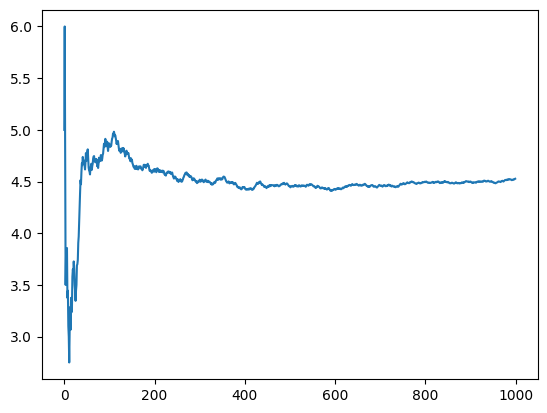

In [43]:
torch.manual_seed(1337)
n = 1000
a = torch.tril(torch.ones(n,n))
a /= a.sum(1, keepdim=True)
b = torch.randint(10, (n,1)).float()
t = time.perf_counter()
c = a @ b
print(time.perf_counter() - t)
#sample
# d = c[::100]
plt.plot(c)
# print(alpha*a)

3.037499845959246e-05


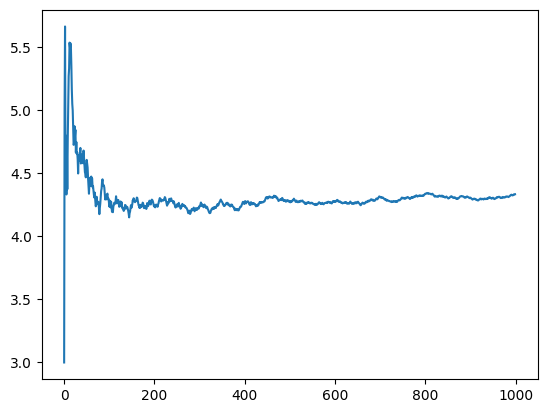

In [36]:
# torch.manual_seed(1337)
mx.random.seed(1337)
n = 1000
# alpha = mx.array([[1/(i+1)] for i in range(n)])
a = mx.tril(mx.ones((n,n)))
a /= a.sum(1, keepdims= True)
b = mx.random.randint(0, 10, (n,1))
t = time.perf_counter()
c = a@ b
print(time.perf_counter() - t)
#sample
# d = c[::100]
plt.plot(c)
# print(alpha*a)

In [11]:
import mlx.optimizers as mlopt

In [31]:
# consider the following toy example
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels (B is batches, T is time but really is context length, C is vocab size?)
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [32]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [33]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T, T) @ (B, T, C) ----> (B, T, C) broadcast as (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

True

In [35]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


True

In [37]:
# so basically set future to -inf to ensure no knowledge. Then the past tokens will have values assigned (currently all the same summing to 1)
# based on how 'relevant' they are to each other. Effectively it becomes a weighted sum + average with unequal weights.

In [56]:
# consider the following toy example
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels (B is batches, T is time but really is context length, C is vocab size? or vocab embedding size?)
x = torch.randn(B,T,C)

#single head self attention
head_size = 16 # hyperparameter
key     =   nn.Linear(C, head_size, bias=False)
query   =   nn.Linear(C, head_size, bias=False)
value   =   nn.Linear(C, head_size, bias=False)


k = key(x) #(B,T,16) every parameter has a key vector of size 16
q = query(x) #(B,T,16) every parameter has a query vector of size 16
wei = q@k.transpose(-2,-1) #(B,T,16) @ (B,16,T)---> (B,T,T) dot product of query and key vectors

tril    =   torch.tril(torch.ones(T,T))
# wei     =   torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
# print(wei[0])
wei = F.softmax(wei, dim = -1)
# print(wei.shape, x.shape)
v = value(x)
out = wei@v
out.shape
# print(wei[0],x[0],out[0])

torch.Size([4, 8, 32])